# Project 3


# Movie Genre Classification

Classify a movie genre based on its plot.

<img src="moviegenre.png"
     style="float: left; margin-right: 10px;" />




https://www.kaggle.com/c/miia4201-202019-p3-moviegenreclassification/overview

### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 20% API
- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 50% Performance in the Kaggle competition (The grade for each group will be proportional to the ranking it occupies in the competition. The group in the first place will obtain 5 points, for each position below, 0.25 points will be subtracted, that is: first place: 5 points, second: 4.75 points, third place: 4.50 points ... eleventh place: 2.50 points, twelfth place: 2.25 points).

• The project must be carried out in the groups assigned for module 4.
• Use clear and rigorous procedures.
• The delivery of the project is on July 12, 2020, 11:59 pm, through Sicua + (Upload: the API and the report in PDF format).
• No projects will be received after the delivery time or by any other means than the one established. 




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Configuraciones Iniciales

In [8]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from time import time
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,  ExtraTreesClassifier
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score, make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegressionCV
import tensorflow as tf
tf.device("gpu:0")
import keras
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Flatten, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
from livelossplot import PlotLossesKeras

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [10]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [11]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


### Create count vectorizer

In [12]:
lemma  = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stp = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

from tqdm import tqdm

In [13]:
preprocessed_plot = []

dataTraining['all'] = str(dataTraining['year'])+' '+dataTraining['title']+' '+dataTraining['plot']
dataTesting['all'] = str(dataTesting['year'])+' '+dataTesting['title']+' '+dataTesting['plot']

for sentance in  pd.concat([dataTraining['all'],dataTesting['all']]).values:
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(decontracted(e.lower()) for e in sentance.split())
    sentance = ' '.join(lemma.lemmatize(w, get_wordnet_pos(w)) for w in sentance.split() if lemma.lemmatize(w, get_wordnet_pos(w)) not in stp)
    preprocessed_plot.append(sentance.strip())

In [14]:
vect=Tokenizer()
vect.fit_on_texts(preprocessed_plot)
encoded = vect.texts_to_sequences(preprocessed_plot)
v_size = len(vect.word_index)
X_padF = sequence.pad_sequences(encoded, maxlen=468)
X_pad = X_padF[:(dataTraining['plot'].shape[0])]
X_padtest = X_padF[(dataTraining['plot'].shape[0]):]

### Create y

In [15]:
dataTraining['genres'] = dataTraining['genres'].map(lambda z: eval(z))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [16]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_pad, y_genres, test_size=0.3, random_state=666)

### Train multi-class multi-label model

In [17]:
#for i in range(0,3):
#  X_train = np.concatenate((X_train,X_train),axis=0)
#  y_train_genres = np.concatenate((y_train_genres,y_train_genres),axis=0)
#(X_train.shape[0], y_train_genres.shape[0])

In [18]:
%matplotlib inline
dim = X_train.shape[1]
output_var = y_train_genres.shape[1]

In [19]:

def auc(y_true, y_pred):
    auc = tf.keras.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [20]:
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 3
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]


In [21]:
K.clear_session()
model = Sequential(name="NLP with multiclass NLP with LSTM")
model.add(Embedding(v_size+1, 4096, input_length=468))
model.add(LSTM(512, input_shape=(dim, ), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(512, use_bias=True, kernel_regularizer=regularizers.l2(l=0.0001)))
model.add(Dropout(0.5))
model.add(Dense(output_var, use_bias=True, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              #optimizer='rmsprop',
              optimizer=keras.optimizers.Adam(lr=0.0001, decay = 1e-5),
#              metrics=['auc']
              #metrics=['accuracy']
              #metrics=[tf.keras.metrics.AUC(multi_label=True)]
              #metrics=[auc_roc]
              )
model.summary()

Model: "NLP with multiclass NLP with LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 468, 4096)         155029504 
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               9439232   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                12312     
Total params: 164,743,704
Trainable params: 164,743,704
Non-trainable params: 0
___________________

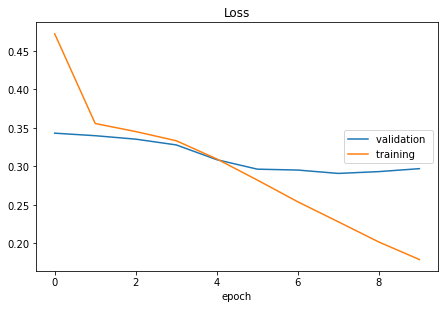

Loss
	validation       	 (min:    0.291, max:    0.343, cur:    0.297)
	training         	 (min:    0.179, max:    0.472, cur:    0.179)


In [22]:
model.fit(X_train,y_train_genres,
          validation_data=[X_test,y_test_genres],
          class_weight='auto',
          epochs=10,  
          batch_size=64,
          verbose=1,
#          callbacks=[PlotLossesKeras(), callbacks_list]
          callbacks=[PlotLossesKeras()]
          )

In [23]:
roc_auc_score(y_test_genres, model.predict_proba(X_test), average='macro')

0.7996339632775511

In [24]:
roc_auc_score(y_train_genres, model.predict_proba(X_train), average='macro')

0.9680606953940577

### Predict the testing dataset

In [26]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model.predict_proba(X_padtest)

In [27]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [28]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,p_Film-Noir,p_History,p_Horror,p_Music,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.055579,0.033596,0.002035,0.005184,0.183006,0.051392,0.001679,0.616492,0.006817,0.028657,0.008489,0.005498,0.051390,0.004782,0.005968,0.054910,0.000519,0.152711,0.029001,0.002369,0.005498,0.166858,0.011789,0.016481
4,0.435483,0.040230,0.007889,0.033047,0.167832,0.574047,0.118921,0.230081,0.008412,0.014957,0.037182,0.025060,0.094767,0.024606,0.005570,0.163918,0.002857,0.007265,0.055917,0.016207,0.022121,0.744800,0.038228,0.053042
5,0.001921,0.001386,0.001069,0.038066,0.749106,0.070253,0.011146,0.887053,0.005818,0.005374,0.007222,0.006003,0.002744,0.109203,0.015499,0.009134,0.000566,0.211350,0.000662,0.002257,0.046122,0.004932,0.006363,0.011840
6,0.091067,0.047190,0.003980,0.110755,0.024857,0.123354,0.013202,0.958246,0.006341,0.028290,0.070803,0.104127,0.029572,0.042333,0.017316,0.072929,0.004439,0.331890,0.033745,0.008001,0.037418,0.288057,0.162779,0.073275
7,0.004156,0.009102,0.010949,0.001913,0.892604,0.003847,0.015077,0.032792,0.081771,0.125197,0.000946,0.000770,0.666190,0.006280,0.008105,0.047364,0.000618,0.007439,0.039436,0.005868,0.009521,0.011199,0.001120,0.004214


In [29]:
res.to_csv('YTP+4096+512.csv', index_label='ID')